# PracticalMachineLearningTutorials: 01 Classification 










## What is classification task?



## Understanding classification terms

## Challenges



### Imbalance classes


### Null values


### Data types

### Small dataset size

ref:
https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook


## Data Preprocessing 



### Normalisation



### Standarization

## Popular Classification Algorithms

### KNN

### Naive Basian

### SVM

### Randome forests

Linear Regression

## Practical Examples

### Iris classification

In [ ]:
# read the dataset
# preprocessing
# plotting
# classification using different classification methods 



### Hand writing Digits classification

### Small dataset




#### Example 1

ref: https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/creativity.jpg)

##### installation

In [113]:
# loading sample dataset from the "don't overfit it" challenge
# 
import warnings
warnings.filterwarnings('ignore')

doInstall  = 0 # install some required libs 
doDownload = 1 # download datasets
useRandom  = 0 # merge datasets then creat new train and test randomly 

if doInstall:
  !pip install six
  !pip install mlrose
  !pip install sklearn 
  !pip install catboost
  !pip install eli5
  !pip install shap
  !pip install mlxtend

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


import shap

import  eli5
from eli5.sklearn import PermutationImportance

import six
import sys
import mlrose

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.classifier import StackingClassifier
sys.modules['sklearn.externals.six'] = six

from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from catboost import CatBoostClassifier

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

##### prepare datasets 

--2023-01-06 10:33:53--  https://raw.githubusercontent.com/idhamari/Machine-Learning-Collection/master/data/smallSatasetChallenge/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482290 (471K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>] 470.99K  --.-KB/s    in 0.01s   

2023-01-06 10:33:53 (32.5 MB/s) - ‘train.csv.1’ saved [482290/482290]

--2023-01-06 10:33:53--  https://github.com/idhamari/Machine-Learning-Collection/raw/master/data/smallSatasetChallenge/test.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/idhamari/Machine-Learning-Collect

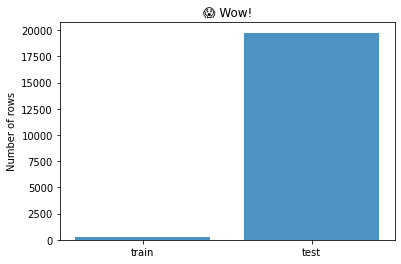

In [51]:

if doDownload:
   trainOnlinePath = 'https://raw.githubusercontent.com/idhamari/Machine-Learning-Collection/master/data/smallSatasetChallenge/train.csv'  # '../input/train.csv'
   testOnlinePath  = 'https://github.com/idhamari/Machine-Learning-Collection/raw/master/data/smallSatasetChallenge/test.csv' # '../input/test.csv'
   sampleOnlinePath= 'https://github.com/idhamari/Machine-Learning-Collection/raw/master/data/smallSatasetChallenge/sample_submission.csv'
   !wget $trainOnlinePath
   !wget $testOnlinePath
   !wget $sampleOnlinePath
   !ls 

trainPath  = 'train.csv'
testPath   = 'test.csv'
samplePath = 'sample_submission.csv' 
#d_names = (trainPath, testPath)

# labels: id, target (0.0 or 1.0), features:0-299 of integers
train       = pd.read_csv(trainPath)
test        = pd.read_csv(testPath)
submission  = pd.read_csv(samplePath)
if useRandom:
   # merge train and test
   data = pd.concat([train, test])
   data =  clean_dataset(data)
   #data = data.reset_index()
   # separate randomly
   #  one can also use,  train = data.sample(n = 250)
   train, test = train_test_split(data, test_size=(1-0.0125), random_state=42, shuffle=True)

# remove non-features columns
features = train.columns.drop(['id', 'target'])

# select target column 
target = train['target']
print("target classes: ", np.unique(target.to_numpy()))

print('Train number of rows:', train.shape[0])
print('Test number of rows: ', test.shape[0])
print('Number of features:  ', features.shape[0])


y_pos = range(2)
 
plt.bar(
    y_pos, 
    (train.shape[0], test.shape[0]), 
    align='center', 
    alpha=0.8
)
plt.xticks(y_pos, ["train", "test"])
plt.ylabel('Number of rows') 
plt.title('😱 Wow!')
plt.show()

##### 1- Small datasets and overfitting

The goal of a machine learning model is to generalize patterns in training data so that you can correctly predict new data that has never been presented to the model. Overfitting occurs when a model adjusts excessively to the training data, seeing patterns that do not exist, and consequently performing poorly in predicting new data:
![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/under_over.png)

The fewer samples for training, the more models can fit our data. In an extreme example (a), for just one training point, any model will be able to "explain" it, however simple or complex the model may be. As we get to have more samples (b, c), fewer models are able to explain them:
![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/few_samples.png)

That way, for a dataset with only 250 samples, we need to be very careful not to be fooled by overfitting. In this kernel we will see some tips that can help.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/meme1.jpeg)






##### 2- Use simple models

As we saw, few samples allow several models to "explain" the data. By thinking graphically, complex models can make crazy curves that will almost perfectly explain the training data, but possibly will perform poorly over the test data.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/overfitting_curve.png)

Avoid complex models with many parameters, thus limiting their generalization and possibility of overfitting. Regularization techniques like L1 and L2 also help make the models more conservative. For tree-based models, reducing their maximum depth also limits the model's ability to see patterns and non-existent relationships.

A good model to get started is Logistic Regression, a linear model used when the dependent variable (target) is categorical (classification tasks).

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/logisticregression.png)

In this model, we can control the regularization by means of the penalty and C parameters (inverse of regularization strength - smaller values specify stronger regularization) to deal with the overfitting:

In [25]:
# solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
#              l2           l2       l1          l2     l1
m = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='lbfgs'
)
m.fit(train[features], target)
m.predict_proba(test[features])[:,1]

array([0.26401709, 0.25774347, 0.21244286, 0.21674814, 0.24261933,
       0.2434624 , 0.23152575, 0.18615293, 0.22245217, 0.21809747,
       0.23063485, 0.24159536, 0.20796447, 0.25617897, 0.25094837,
       0.20275151, 0.33119196, 0.19397065, 0.30510486, 0.25856294,
       0.23744949, 0.25432414, 0.22513835, 0.23954183, 0.27633707,
       0.22536489, 0.24964772, 0.28162285, 0.21875485, 0.24953528,
       0.22022905, 0.25441903, 0.18580805, 0.28436233, 0.23335701,
       0.28230981, 0.20402918, 0.2702417 , 0.31730376, 0.15394143,
       0.25782528, 0.24846053, 0.2478563 , 0.22126049, 0.21254977,
       0.20689147, 0.2714977 , 0.21909107, 0.25733903, 0.2890178 ,
       0.16543327, 0.33027101, 0.19422231, 0.28521251, 0.17936328,
       0.22829702, 0.29140613, 0.31152688, 0.26157494, 0.18571216,
       0.24425735, 0.22030157, 0.26677569, 0.32286525, 0.27713113,
       0.23841216, 0.22855279, 0.17861909, 0.28578958, 0.25058878,
       0.26980076, 0.24208429, 0.30155477, 0.29416845, 0.23259



For tree-based models like XGBoost, we can control the overfitting by tuning a series of parameters:

- Restricting the maximum depth of trees via max_depth (low values)
- Making the model more conservative via gamma and eta (high values)
- L1 and L2 regularization via reg_alpha and reg_lambda (high values)



In [26]:
m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
m.fit(train[features], target)
m.predict_proba(test[features])[:,1]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

Note that because it is a nonlinear model with several parameters, it tends to be more prone to overfitting than a simple linear model such as logistic regression.





##### 3- Beware the outliers

Outliers are extreme values that fall a long way outside of the other observations. In a small dataset, the impact of an outlier can be much greater, since it will have a heavy weight for the model:

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/outlier.png)

The scikit-learn library has several implementations of outliers detection techniques:
![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/outl_detection.png)

Let's do an experiment with the IsolationForest technique, which uses random forests for efficient detection of outliers in high-dimensional datasets. From scikit-learn documentation:

 - The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
 - Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.
 - This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

    

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/isolation_forest.jpg)

Let's score each sample of our dataset using a isolation forest (the lower, the more abnormal):

In [27]:


isf = IsolationForest(n_jobs=-1, random_state=1)
isf.fit(train[features], train['target'])

print(isf.score_samples(train[features]))

[-0.3878091  -0.3878091  -0.37683555]




Now, let's predict the outliers (1 for inliers, -1 for outliers):


In [28]:
isf.predict(train[features])

array([1, 1, 1])

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)



Beware, with few samples, it becomes a challenge to adjust the algorithms to correctly identify the outliers.




#####  4- Select the features
 
While removing outliers consists of deleting rows from the dataset, feature selection consists of deleting columns that do not contribute to the prediction. There is a wide variety of methods, such as analysis of its correlation with the target, importance analysis and recursive elimination.

Let's see an example of how to identify the most relevant features for classification using a tree model:

In [29]:
TOP_FEATURES = 15

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
forest.fit(train[features], train['target'])

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))

Top features:
1. feature 255 (0.024000)
2. feature 283 (0.020000)
3. feature 36 (0.020000)
4. feature 38 (0.016000)
5. feature 180 (0.016000)
6. feature 90 (0.016000)
7. feature 191 (0.016000)
8. feature 177 (0.016000)
9. feature 291 (0.016000)
10. feature 243 (0.016000)
11. feature 48 (0.016000)
12. feature 68 (0.016000)
13. feature 228 (0.016000)
14. feature 134 (0.012000)
15. feature 127 (0.012000)




We can plot a chart of the importances:


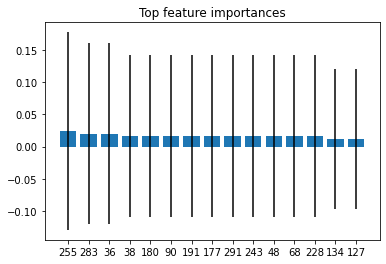

In [30]:
plt.figure()
plt.title('Top feature importances')
plt.bar(
    range(TOP_FEATURES), 
    importances[indices],
    yerr=std[indices], 
)
plt.xticks(range(TOP_FEATURES), indices)
plt.show()



In the next example, we will try to identify the most important features by successively training a model and recursively eliminating those that do not contribute to a good final solution (according to the selected model).

We will use the recursive feature elimination RFE from the scikit-learn library and the XGBClassifier model:


In [31]:


rfe = RFE(XGBClassifier(n_jobs=-1, random_state=1))

rfe.fit(train[features], train['target'])

print('Selected features:')
print(features[rfe.support_].tolist())

ValueError: ignored



Caution: for a very small dataset, very robust local validation is required to determine whether or not a feature contributes to the final solution.




##### 5- Balance the dataset with synthetic samples (SMOTE)


Let's look at the distribution of target values:

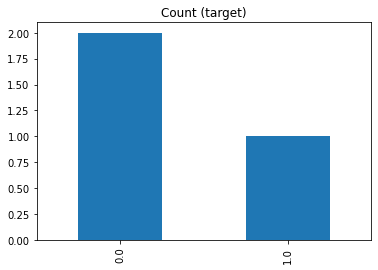

In [32]:
train['target'].value_counts().plot(kind='bar', title='Count (target)');

In addition to being extremely small, our training dataset has the unbalanced target binary variable, which can undermine some models' predictability. We will perform an oversampling, which consists of creating new samples to increase the 0 minority class. For this we will use the SMOTE technique.

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.
![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

We'll use the SMOTE implementation from the library imbalanced-learn, with the parameter ratio='minority' to resample the minority class:

In [33]:
smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(train[features], train['target'])

df = pd.DataFrame(X_sm, columns=features)
df['target'] = y_sm

df['target'].value_counts().plot(kind='bar', title='Count (target)');

ValueError: ignored

Using TensorFlow backend.




#####  6- Combine models for the final submission

Combine the prediction of several models or the same model with different values of hyperparameters reduces variance and enhances generalization.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

Often, combining weak models that are poorly correlated with each other can lead to superior results than a strong individual model. There are several ways to do this. The simplest is to perform a weighted average of the various predictions:


In [34]:
models = [
    LogisticRegression(),
    XGBClassifier(max_depth=2)
]

preds = pd.DataFrame()
for i, m in enumerate(models):
    m.fit(train[features], target),
    preds[i] = m.predict_proba(test[features])[:,1]

weights = [1, 0.3]
preds['weighted_pred'] = (preds * weights).sum(axis=1) / sum(weights)
preds.head()

,0,1,weighted_pred
0,0.187085,0.335869,0.221420
1,0.179140,0.335869,0.215308
2,0.124155,0.335869,0.173012
3,0.128510,0.335869,0.176362
4,0.159805,0.335869,0.200435


Another more sophisticated way of combining predictions is the use of a meta-classifier, which receives as input the prediction of other classifiers, and performs the final predict. From the mlxtend library documentation:

    Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/stack.png)

As an example, we will use the StackingClassifier of the mlxtend library:


In [35]:
m = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        XGBClassifier(max_depth=2)
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

m.fit(train[features], target),
preds['stack_pred'] = m.predict_proba(test[features])[:,1]
preds.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=0881c2af78efdc8dac1671f25bed0f4e784d17b578f3f8d5349f4952d2c53ae6
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


,0,1,weighted_pred,stack_pred
0,0.187085,0.335869,0.221420,0.294749
1,0.179140,0.335869,0.215308,0.293086
2,0.124155,0.335869,0.173012,0.281733
3,0.128510,0.335869,0.176362,0.282623
4,0.159805,0.335869,0.200435,0.289064


![](https://raw.githubusercontent.com/rafjaa/curso-mineracao-de-dados-aplicada/master/img/kernel_overfitting/mem2.jpg)


##### References

Overfitting:

    IRIC's Bioinformatics Platform. Overfitting and Regularization. https://bioinfo.iric.ca/overfitting-and-regularization/
    PATNI, Shubham. Generalisation, Training-Validation & Test data. Machine Learning- Part 6. https://medium.com/@shubhapatnim86/generalisation-training-validation-test-data-machine-learning-part-6-1de9dbb7d3d5
    Rants on Machine Learning. What to do with “small” data? https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89
    Towards Data Science. Breaking the curse of small datasets in Machine Learning: Part 1. https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d

Models:

    scikit-learn. LogisticRegression. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    Towards Data Science. Logistic Regression — Detailed Overview. https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc
    XGBoost. XGBoost Parameters. https://xgboost.readthedocs.io/en/latest/parameter.html

Outlier detection:

    Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM‘08. Eighth IEEE International Conference on.
    Machine Learning Valencia. Anomaly Detection. Valencian Summer School 2015. https://www.slideshare.net/mlvlc/l14-anomaly-detection
    scikit-learn. Novelty and Outlier Detection. https://scikit-learn.org/stable/modules/outlier_detection.html
    VADALI, SaiGayatri.Day 7: Data cleaning — All you need to know about it. https://becominghuman.ai/day-7-data-cleaning-all-that-you-need-to-know-about-it-23b05738abe7

Feature selection:

    scikit-learn. Feature selection. https://scikit-learn.org/stable/modules/feature_selection.html

SMOTE

    ALENCAR, Rafael. Resampling strategies for imbalanced datasets. https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002)
    imbalanced-learn. https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

Stacking

    mlxtend. StackingClassifier. http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
    Tang, J., S. Alelyani, and H. Liu. "Data Classification: Algorithms and Applications." Data Mining and Knowledge Discovery Series, CRC Press (2015): pp. 498-500.
    Wolpert, David H. "Stacked generalization." Neural networks 5.2 (1992): 241-259.



#### Example 2

ref: https://www.kaggle.com/code/pro1amr/don-t-overfit 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 590.0 KB


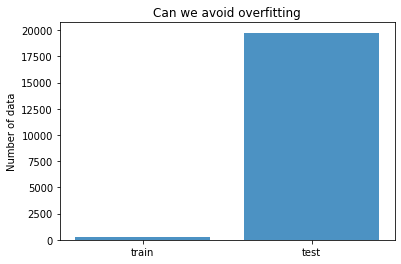

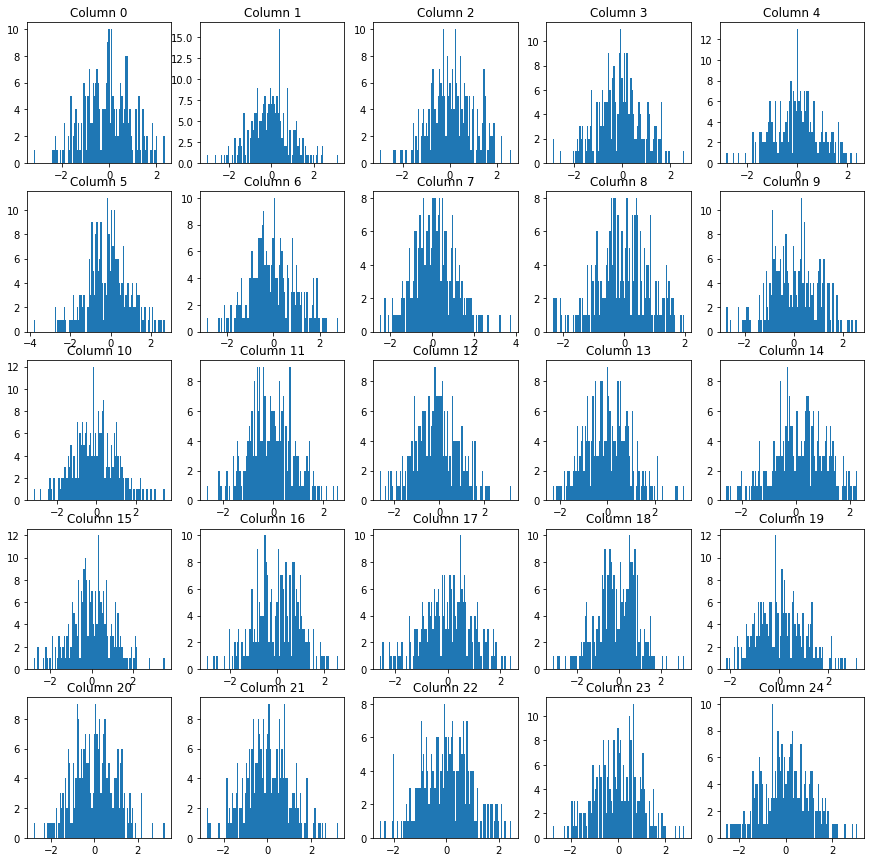

0.41172020000000004
1.2443133789158767
6.871111111111117e-08
0.0033342908871973214
Fitting 7 folds for each of 2 candidates, totalling 14 fits
[CV 1/7] END max_depth=11, min_samples_leaf=9, min_samples_split=9, n_estimators=250;, score=0.500 total time=   0.3s
[CV 2/7] END max_depth=11, min_samples_leaf=9, min_samples_split=9, n_estimators=250;, score=0.500 total time=   0.3s
[CV 3/7] END max_depth=11, min_samples_leaf=9, min_samples_split=9, n_estimators=250;, score=0.500 total time=   0.3s
[CV 4/7] END max_depth=11, min_samples_leaf=9, min_samples_split=9, n_estimators=250;, score=0.500 total time=   0.3s
[CV 5/7] END max_depth=11, min_samples_leaf=9, min_samples_split=9, n_estimators=250;, score=0.500 total time=   0.3s
[CV 6/7] END max_depth=11, min_samples_leaf=9, min_samples_split=9, n_estimators=250;, score=0.500 total time=   0.3s
[CV 7/7] END max_depth=11, min_samples_leaf=9, min_samples_split=9, n_estimators=250;, score=0.500 total time=   0.3s
[CV 1/7] END max_depth=11, min_

In [45]:


import sys, os
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt



from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt



def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

rfe_min_features = 12
rfe_step = 15
rfe_cv = 20
sss_n_splits = 20
sss_test_size = 0.35
grid_search_cv = 20
noise_std = 0.01
r2_threshold = 0.185
random_seed = 213

np.random.seed(random_seed)

# import data
#train = pd.read_csv('../input/older-dataset-for-dont-overfit-ii-challenge/train.csv')
train_y = train['target']
train_X = train.drop(['id','target'], axis=1).values

#test_df = pd.read_csv('../input/older-dataset-for-dont-overfit-ii-challenge/test.csv')
test_df = test
test_df= test_df.drop(['id'], axis=1).values
train.head()
train.info()
train.nunique()


#number of training samples is too small
plt.bar(range(2), (train_X.shape[0], test_df.shape[0]), align='center', alpha=0.8)
plt.xticks(range(2), ('train','test'))
plt.ylabel('Number of data') 
plt.title('Can we avoid overfitting')
plt.show()


#from the hist of each column it shows that data follows a gaussian shape or normal distribution around 0 mean and std =1
plt.figure(figsize=(15,15))
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        plt.hist(train[str(5*i+j)],bins=100)
        plt.title('Column '+str(5*i+j))
plt.show()



#check the mean value and std on the train 

# with mean 0 and std 1 
print(train.mean().sum()/300)
print(train.std().sum()/300)



#check the mean value and std on the Test Data 
print(test_df.mean().sum()/300)
print(test_df.std().sum()/300)



# scale using RobustScaler 
data = RobustScaler().fit_transform(np.concatenate((train_X, test_df), axis=0))
train_X = data[:250]
test_df= data[250:]
# add a bit of noise to train_X to reduce overfitting
train_X += np.random.normal(0, noise_std, train_X.shape)



# define roc_auc_metric 
#then make it as ascorer 
def scoring_roc_auc(y, y_pred):
    try:
        return roc_auc_score(y, y_pred)
    except:
        return 0.5

robust_roc_auc = make_scorer(scoring_roc_auc)




#Draw Correlation heatmap
train.drop(columns=['id','target']).corr()



#Try hist gradient classifier without any normalization on the data then get the most important features 

HistGradient = ExtraTreesClassifier(warm_start=True)

param = {'n_estimators' : [250,500], 
    'max_depth' : [11],
   
         'min_samples_split':[9],
         'min_samples_leaf':[9],
        }

gridSearch_HistGradient = GridSearchCV(HistGradient,param,scoring=robust_roc_auc,cv=7,verbose=3)
gridSearch_HistGradient.fit(train_X, train_y)

best_HistGradient = gridSearch_HistGradient.best_estimator_
bestHistGradient_testScore=best_HistGradient.score(train_X, train_y)



### Feature selection using RFECV on Lasso

# define Laso model and its parameters
#Lasso uses L1 normalization
model = Lasso(alpha=0.031, tol=0.01,warm_start=True, random_state=random_seed, selection='random')

param_grid = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
        }

# define recursive elimination feature selector
feature_selector = RFECV(model, min_features_to_select=rfe_min_features, scoring=robust_roc_auc, step=rfe_step, verbose=0, cv=rfe_cv, n_jobs=-1)

predictions = pd.DataFrame()
counter = 0
print("counter | val_mse  |  val_mae  |  val_roc  |  val_cos  |  val_dist  |  val_r2    | feature_count ")
print("-------------------------------------------------------------------------------------------------")
# split training data to build one model on each traing-data-subset
for train_index, val_index in StratifiedShuffleSplit(n_splits=sss_n_splits, test_size=sss_test_size, random_state=random_seed).split(train_X, train_y):
    X, val_X = train_X[train_index], train_X[val_index]
    y, val_y = train_y[train_index], train_y[val_index]

    # get the best features for this data set
    feature_selector.fit(X, y)
    # remove irrelevant features from X, val_X and test
    X_important_features        = feature_selector.transform(X)
    val_X_important_features    = feature_selector.transform(val_X)
    test_important_features     = feature_selector.transform(test_df)

    # run grid search to find the best Lasso parameters for this subset of training data and subset of features 
    grid_search = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0, n_jobs=-1, scoring=robust_roc_auc, cv=20)
    grid_search.fit(X_important_features, y)

    # score  fitted model on validation data
    val_y_pred = grid_search.best_estimator_.predict(val_X_important_features)
    val_mse = mean_squared_error(val_y, val_y_pred)
    val_mae = mean_absolute_error(val_y, val_y_pred)
    val_roc = roc_auc_score(val_y, val_y_pred)
    val_cos = cosine_similarity(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(val_y, val_y_pred)

    # if model did well on validation, save its prediction on test data, using only important features
    # r2_threshold (0.185) is a heuristic threshold for r2 error
    # you can use any other metric/metric combination that works for you
    if val_r2 > r2_threshold:
        message = '<-- OK'
        prediction = grid_search.best_estimator_.predict(test_important_features)
        predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
    else:
        message = '<-- skipping'


    print("{0:2}      | {1:.4f}   |  {2:.4f}   |  {3:.4f}   |  {4:.4f}   |  {5:.4f}    |  {6:.4f}    |  {7:3}         {8}  ".format(counter, val_mse, val_mae, val_roc, val_cos, val_dst, val_r2, feature_selector.n_features_, message))
    
    counter += 1

print("-------------------------------------------------------------------------------------------------")
print("{}/{} models passed validation threshold and will be ensembled.".format(len(predictions.columns), sss_n_splits))

mean_pred = pd.DataFrame(predictions.mean(axis=1))
mean_pred.index += 250
mean_pred.columns = ['target']
print("-----------------------------------------")
print("mean_pred: ",mean_pred)


#mean_pred.to_csv('submission.csv', index_label='id', index=True) 

#### Example3 How to not overfit?

ref: https://www.kaggle.com/code/artgor/how-to-not-overfit/notebook


**General information**

In Don't Overfit! II competition we have a binary classification task. 300 columns, 250 training samples and 79 times more samples in test data! We need to be able to build a model without overfitting.

In this kernel I'll write the following things:

- EDA on the features and trying to get some insights;
- Using permutation importance to select most impactful features;
- Comparing various models: bayer classification, linear models, tree based models;
- Trying various approaches to feature selection including taking top features from eli5 and shap;
- Hyperparameter optimization for models;
- Feature generation;
- Other things;
![](https://cdn-images-1.medium.com/max/1600/1*vuZxFMi5fODz2OEcpG-S1g.png)


##### 1- Data exploration

In [57]:
print(train.shape)
print(train.head())
print(train.info())

(250, 302)
   id  target      0      1      2      3      4      5      6      7  ...  \
0   0     1.0 -1.067 -1.114 -0.616  0.376  1.090  0.467 -0.422  0.460  ...   
1   1     0.0 -0.831  0.271  1.716  1.096  1.731 -0.197  1.904 -0.265  ...   
2   2     0.0  0.099  1.390 -0.732 -1.065  0.005 -0.081 -1.450  0.317  ...   
3   3     1.0 -0.989 -0.916 -1.343  0.145  0.543  0.636  1.127  0.189  ...   
4   4     0.0  0.811 -1.509  0.522 -0.360 -0.220 -0.959  0.334 -0.566  ...   

     290    291    292    293    294    295    296    297    298    299  
0  0.220 -0.339  0.254 -0.179  0.352  0.125  0.347  0.436  0.958 -0.824  
1 -0.765 -0.735 -1.158  2.554  0.856 -1.506  0.462 -0.029 -1.932 -0.343  
2 -1.311  0.799 -1.001  1.544  0.575 -0.309 -0.339 -0.148 -0.646  0.725  
3 -1.370  1.093  0.596 -0.589 -0.649 -0.163 -0.958 -1.081  0.805  3.401  
4 -0.178  0.718 -1.017  1.249 -0.596 -0.445  1.751  1.442 -0.393 -0.643  

[5 rows x 302 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25

Text(0.5, 1.0, 'Distribution of stds of all columns')

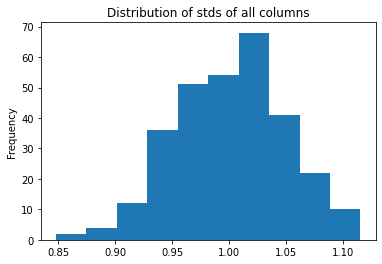

In [58]:
train[train.columns[2:]].std().plot(kind='hist');
plt.title('Distribution of stds of all columns')

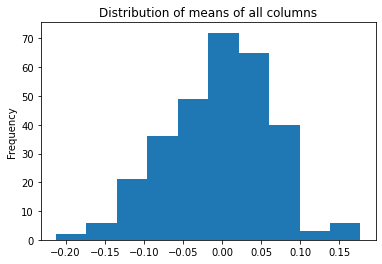

In [59]:
train[train.columns[2:]].mean().plot(kind='hist');
plt.title('Distribution of means of all columns');

Null values?  False
Distributions of first 28 columns


0.0    183
1.0     67
Name: target, dtype: int64

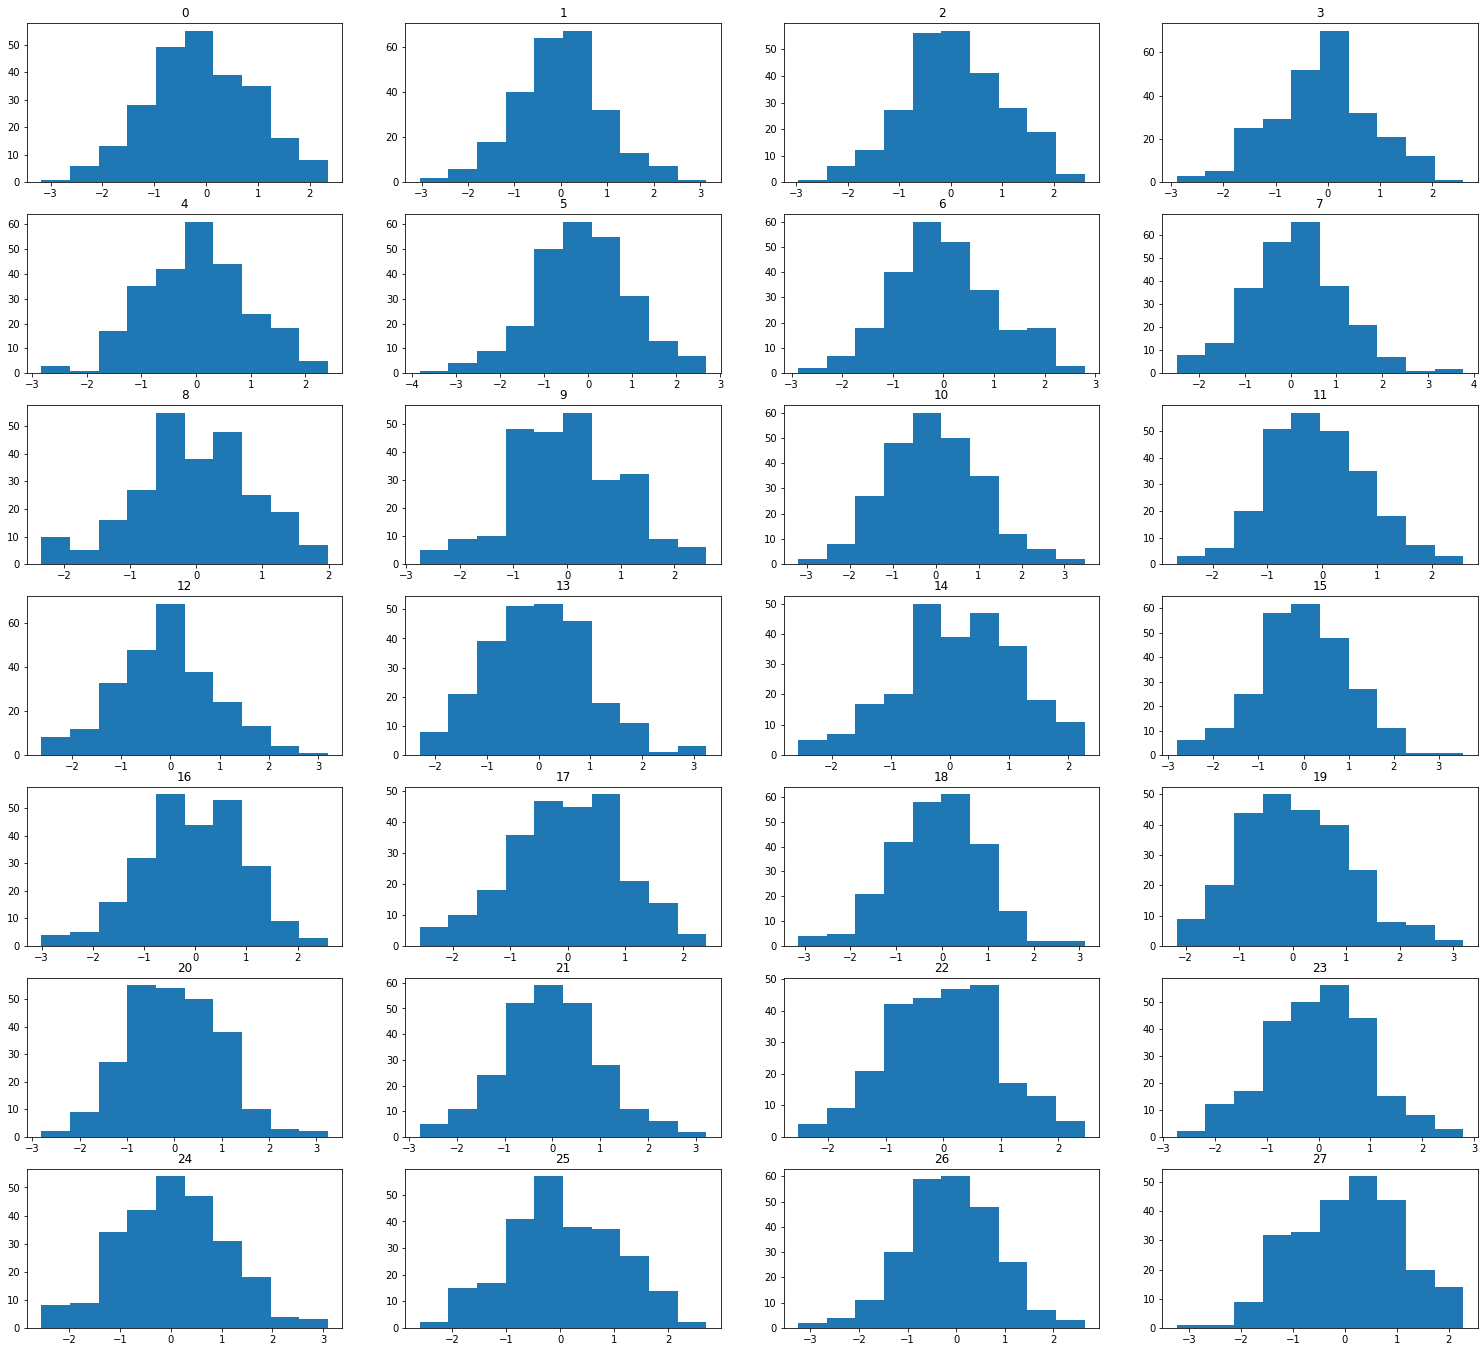

In [60]:
# we have no missing values
print("Null values? ", train.isnull().any().any())



print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)


train['target'].value_counts()



From this overview we can see the following things:

- target is binary and has some disbalance: 36% of samples belong to 0 class;
- values in columns are more or less similar;
- columns have std of 1 +/- 0.1 (min and max values are 0.889, 1.117 respectively);
- columns have mean of 0 +/- 0.15 (min and max values are -0.2, 0.1896 respectively);

Let's have a look at correlations now!


In [61]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,219,279,0.238512
90893,279,219,0.238512
90894,23,20,0.246984
90895,20,23,0.246984
90896,146,228,0.258447
90897,228,146,0.258447
90898,6,39,0.267727
90899,39,6,0.267727
90900,127,target,0.337540
90901,target,127,0.337540




We can see that correlations between features are lower that 0.3 and the most correlated feature with target has correlation of 0.37. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.


##### 2- Basic modelling

In [75]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores
print("done!!!")

done!!!


In [76]:

# A lot of people are using logreg currently, let's try
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7431, std: 0.1357.


In [78]:
# A lot of people are using logreg currently, let's try
cat_params = {'learning_rate': 0.02,
              'depth': 5,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=cat_params, model_type='cat')

CV mean score: 0.5083, std: 0.0363.


In [79]:
model = CatBoostClassifier(iterations=400,  eval_metric='AUC', **cat_params)
model.fit(X_train, y_train, cat_features=[], use_best_model=True, verbose=200)


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 42.3ms	remaining: 16.9s
200:	total: 7.54s	remaining: 7.46s
399:	total: 14.9s	remaining: 0us


In [81]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr_repeated, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)


CV mean score: 0.7071, std: 0.1428.


##### 3- ELI5

ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

In [87]:
eli5.show_weights(model, top=50)


Weight?,Feature
+0.568,x127
+0.346,x18
+0.162,x66
+0.123,x241
+0.090,x32
+0.090,x260
+0.077,x93
+0.055,x178
+0.038,x213
+0.033,x208


In [88]:
(model.coef_ != 0).sum()


35

We can see that There are several features with highly positive weights and more features with negative weights. In fact there are only 32 features, which are important according to ELI5. It is worth noticing though, that the model itself had 34 non-zero features, so ELI5 dropped only 2 features.. Let's try using only them for the submission!

In [89]:


top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)



CV mean score: 0.7456, std: 0.1317.


Wow, we got improvement from 0.7226 to 0.7486 on CV! But this submission gives 0.845 on leaderboard. So it decreases score slightly. Let's try other things

**Permutation importance**

There is also another way of using eli5 - we could have a look at permutation importance. It works in the following way:

- We fit a model;
- We randomly shuffle one column of validation data and calculate the score;
- If the score dropped significantly, it means that the feature is important;

You can read more about this approach here: https://www.kaggle.com/dansbecker/permutation-*importance*

In [93]:

perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50)





Weight,Feature
0.0312 ± 0.0425,x33
0.0024 ± 0.0165,x5
0.0008 ± 0.0032,x19
0 ± 0.0000,x10
0 ± 0.0000,x15
0 ± 0.0000,x14
0 ± 0.0000,x13
0 ± 0.0000,x12
0 ± 0.0000,x11
0 ± 0.0000,x34


In [94]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr1, prediction_lr1, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.5640, std: 0.1368.




Wow, if we select columns by permutation importance, CV score drops significantly. It seems it doesn't work well in our case.


##### 4- SHAP

Another interesting tool is SHAP. It also provides explanations for a variety of models.


CV mean score: 0.7431, std: 0.1357.


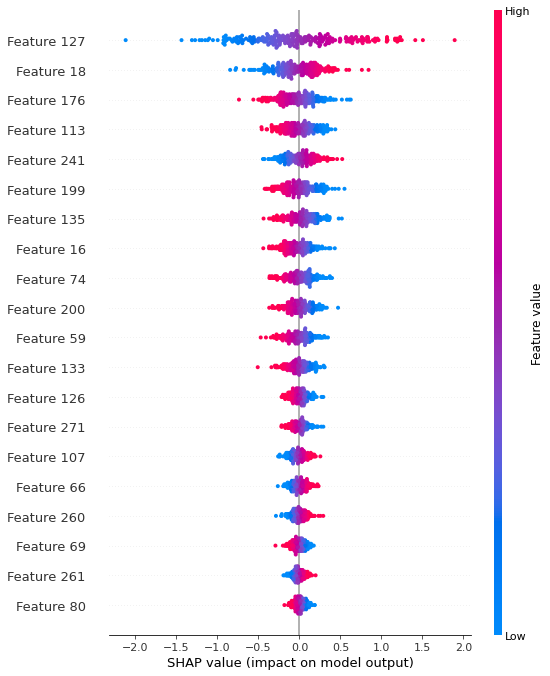

In [99]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)


explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)



It could be difficult to interpret this plot when you see it for the first time. It shows how features impact predictions. For example for feature 33 low values have a negative impact on model predictions (zero is more likely), and high values have a positive impace (ones are more likely). Feature 217 has an opposite effect: low values have a positive impact and high values have a negative impact.

But we will need to select features manually... let's use a library for that!


##### 5- Mlextend SequentialFeatureSelector

In [108]:
sfs1 = SFS(model, 
           k_features=(10, 15), 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='roc_auc',
           cv=folds)

sfs1 = sfs1.fit(X_train, y_train)
print("done!!!")

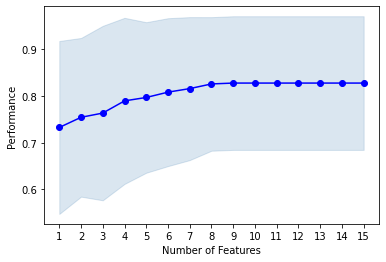

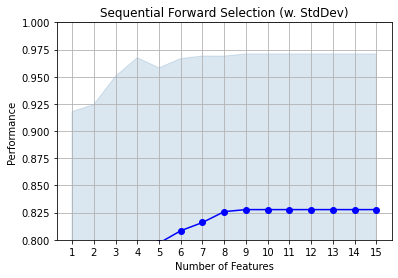

In [114]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [115]:
top_features = list(sfs1.k_feature_names_)
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("done!!!")

done!!!


In [116]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7301, std: 0.1561.




And this gives 0.811 on leaderboard. Overfitting! It seems that feature selection isn't the best approach. Let's try building various models!


##### 6- Modelling

In [118]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = linear_model.LogisticRegression(solver='liblinear', max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'solver': ['newton-cg', 'sag', 'lbfgs']
                 }

In [120]:
grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7044444444444445
Best parameters: {'C': 100.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'}


In [123]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0],
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7830555555555557
Best parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}


In [122]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7431, std: 0.1357.


In [124]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
oof_gnb, prediction_gnb, scores_gnb = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=gnb)

CV mean score: 0.5462, std: 0.0910.


In [125]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

parameter_grid = {'n_estimators': [5, 10, 20, 50, 100],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
                 }

grid_search = GridSearchCV(abc, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.6804629629629629
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [126]:
abc = AdaBoostClassifier(**grid_search.best_params_)
oof_abc, prediction_abc, scores_abc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=abc)

CV mean score: 0.5625, std: 0.1363.


In [128]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

parameter_grid = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(etc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7118518518518518
Best parameters: {'max_depth': 5, 'n_estimators': 1000}


In [129]:
etc = ExtraTreesClassifier(**grid_search.best_params_)
oof_etc, prediction_etc, scores_etc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=etc)

CV mean score: 0.5000, std: 0.0000.


In [130]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.6557407407407408
Best parameters: {'max_depth': 15, 'n_estimators': 1000}


In [131]:
rfc = RandomForestClassifier(**grid_search.best_params_)
oof_rfc, prediction_rfc, scores_rfc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=rfc)

CV mean score: 0.5000, std: 0.0000.


In [132]:
from sklearn.gaussian_process import GaussianProcessClassifier
gpc = GaussianProcessClassifier()
oof_gpc, prediction_gpc, scores_gpc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=gpc)

CV mean score: 0.5504, std: 0.1508.


In [133]:
from sklearn.svm import SVC
svc = SVC(probability=True, gamma='scale')

parameter_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                  'kernel': ['linear', 'poly', 'rbf'],
                 }

grid_search = GridSearchCV(svc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.6980555555555554
Best parameters: {'C': 10.0, 'kernel': 'rbf'}


In [134]:
svc = SVC(probability=True, gamma='scale', **grid_search.best_params_)
oof_svc, prediction_svc, scores_svc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=svc)

CV mean score: 0.4975, std: 0.0444.


In [135]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

parameter_grid = {'n_neighbors': [2, 3, 5, 10, 20],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [5, 10, 30]
                 }

grid_search = GridSearchCV(knc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5949074074074073
Best parameters: {'leaf_size': 5, 'n_neighbors': 20, 'weights': 'distance'}


In [136]:
knc = KNeighborsClassifier(**grid_search.best_params_)
oof_knc, prediction_knc, scores_knc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=knc)

CV mean score: 0.5000, std: 0.0000.


In [137]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

parameter_grid = {'alpha': [0.0001, 1, 2, 10]
                 }

grid_search = GridSearchCV(bnb, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5453703703703704
Best parameters: {'alpha': 2}


In [138]:
bnb = BernoulliNB(**grid_search.best_params_)
oof_bnb, prediction_bnb, scores_bnb = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=bnb)

CV mean score: 0.4792, std: 0.1370.


In [139]:
sgd = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001)

parameter_grid = {'loss': ['log', 'modified_huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

grid_search = GridSearchCV(sgd, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7474074074074074
Best parameters: {'alpha': 0.01, 'l1_ratio': 0, 'learning_rate': 'adaptive', 'loss': 'log', 'penalty': 'l1'}


In [140]:
sgd = linear_model.SGDClassifier(eta0=1, tol=0.0001, **grid_search.best_params_)
oof_sgd, prediction_sgd, scores_sgd = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=sgd)

CV mean score: 0.6121, std: 0.1509.


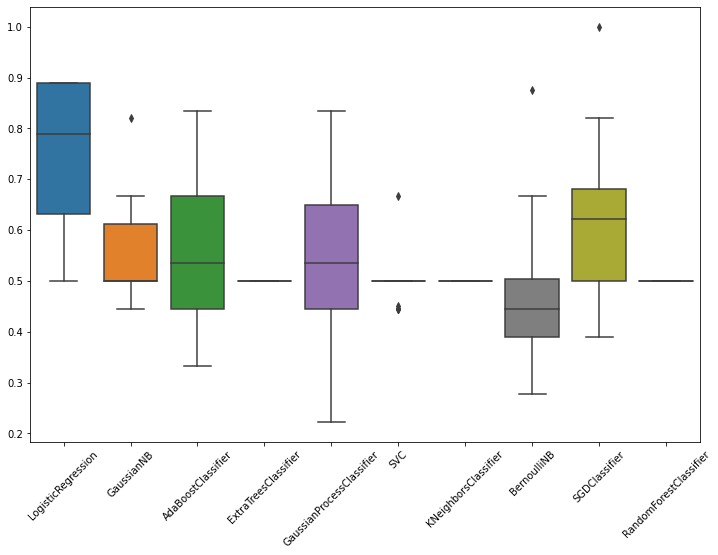

In [141]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'LogisticRegression': scores})
scores_df['GaussianNB'] = scores_gnb
scores_df['AdaBoostClassifier'] = scores_abc
scores_df['ExtraTreesClassifier'] = scores_etc
scores_df['GaussianProcessClassifier'] = scores_gpc
scores_df['SVC'] = scores_svc
scores_df['KNeighborsClassifier'] = scores_knc
scores_df['BernoulliNB'] = scores_bnb
scores_df['SGDClassifier'] = scores_sgd
scores_df['RandomForestClassifier'] = scores_rfc

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);



We can see that logistic regression is superior to most other models. Only SVC is comparable. It seems that other models either overfit or can't work on this small dataset.

Let's try submitting a blend of them!


CV mean score: 0.7431, std: 0.1357.


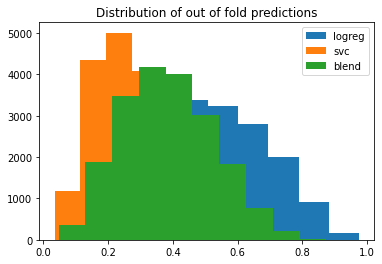

In [142]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

plt.hist(prediction_lr, label='logreg');
plt.hist(prediction_svc, label='svc');
plt.hist((prediction_lr + prediction_svc) / 2, label='blend');
plt.title('Distribution of out of fold predictions');
plt.legend();



Sadly blend gives 0.831 on LB. Again no luck.

Let's try generating some features!


##### 7- Polynomial features


In [143]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

The number of polynomial features is ~45k which is too much. We need some way to select some of them. Let's try use correlations with target.

In [144]:
cor = pd.DataFrame(X_train_poly).corrwith(y_train)
sc = []
for i in range(10, 510, 5):
    top_corr_cols = list(cor.abs().sort_values().tail(i).reset_index()['index'].values)
    X_train_poly1 = X_train_poly[:, top_corr_cols]
    X_test_poly1 = X_test_poly[:, top_corr_cols]
    oof_lr_poly, prediction_lr_poly, scores = train_model(X_train_poly1, X_test_poly1, y_train, params=None, model_type='sklearn', model=model)
    sc.append(scores)

    data = [go.Scatter(
        x = list(range(10, 510, 5)),
        y = [np.round(np.mean(i), 4) for i in sc],
        name = 'CV scores'
    )]
layout = go.Layout(dict(title = "Top N poly features vs CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')



CV mean score: 0.7686, std: 0.1499.


NameError: ignored



Not suprisingly we overfit.


In [ ]:
top_corr_cols = list(cor.abs().sort_values().tail(300).reset_index()['index'].values)
X_train_poly1 = X_train_poly[:, top_corr_cols]
X_test_poly1 = X_test_poly[:, top_corr_cols]

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_poly, prediction_lr_poly, scores = train_model(X_train_poly1, X_test_poly1, y_train, params=None, model_type='sklearn', model=model)


In [ ]:
#submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_poly
# submission.to_csv('submission_poly.csv', index=False)

submission.head()





Score became much lower. So this is also a bad idea


##### 8- Adding statistics


In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
X_train['300'] = X_train.std(1)
X_test['300'] = X_test.std(1)
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)



Let's compare with repeated KFold.


In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
X_train['300'] = X_train.std(1)
X_test['300'] = X_test.std(1)
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1_repeated, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_1_repeated
submission.to_csv('repeated_fold_features.csv', index=False)

submission.head()



CV increased a bit!


##### 9- Adding distance features


In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
main_cols = X_train.columns.tolist()

neigh = NearestNeighbors(5, n_jobs=-1)
neigh.fit(X_train)

dists, _ = neigh.kneighbors(X_train, n_neighbors=5)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train['300'] = X_train.std(1)
X_train = np.hstack((X_train, mean_dist.reshape(-1, 1), max_dist.reshape(-1, 1), min_dist.reshape(-1, 1)))

test_dists, _ = neigh.kneighbors(X_test, n_neighbors=5)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test['300'] = X_test.std(1)
X_test = np.hstack((X_test, test_mean_dist.reshape(-1, 1), test_max_dist.reshape(-1, 1), test_min_dist.reshape(-1, 1)))

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_2, prediction_lr_2, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)
submission['target'] = prediction_lr_2
submission.to_csv('nn_features.csv', index=False)

In [ ]:
#submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = (prediction_lr_1 + prediction_lr_2) / 2
# submission.to_csv('blend.csv', index=False)

submission.head()

##### 10- Sklearn feature selection

Sklearn has several methods to do feature selection. Let's try some of them!

In [ ]:
# baseline score
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
scores_dict = {'f_classif': [], 'mutual_info_classif': []}
for i in range(5, 100, 5):
    s1 = SelectPercentile(f_classif, percentile=i)
    X_train1 = s1.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectPercentile(mutual_info_classif, percentile=i)
    X_train1 = s2.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['mutual_info_classif'].append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(5, 100, 5)),
        y = scores_dict['f_classif'],
        name = 'CV scores f_classif'
    ), go.Scatter(
        x = list(range(5, 100, 5)),
        y = scores_dict['mutual_info_classif'],
        name = 'CV scores mutual_info_classif')]
layout = go.Layout(dict(title = "Top N features by percentile vs CV",
                  xaxis = dict(title = 'Top N features by percentile'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
scores_dict = {'f_classif': [], 'mutual_info_classif': []}
for i in range(10, 301, 10):
    s1 = SelectKBest(f_classif, k=i)
    X_train1 = s1.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectKBest(mutual_info_classif, k=i)
    X_train1 = s2.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['mutual_info_classif'].append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(10, 301, 10)),
        y = scores_dict['f_classif'],
        name = 'CV scores f_classif'
    ), go.Scatter(
        x = list(range(10, 301, 10)),
        y = scores_dict['mutual_info_classif'],
        name = 'CV scores mutual_info_classif')]
layout = go.Layout(dict(title = "Top N features by SelectKBest vs CV",
                  xaxis = dict(title = 'Top N features by SelectKBest'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')



In [ ]:
selector = SelectKBest(f_classif, k=60)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)
oof_lr_1, prediction_lr_1, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
#submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_1
# submission.to_csv('top_n_features.csv', index=False)

submission.head()

In [ ]:
scores_list = []
for i in range(10, 301, 5):
    s = RFE(model, i, step=1)
    X_train1 = s.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_list.append(np.mean(scores))

In [ ]:
data = [go.Scatter(
        x = list(range(10, 301, 5)),
        y = scores_list,
        name = 'CV scores RFE'
    )]
layout = go.Layout(dict(title = "Top N features by RFE vs CV",
                  xaxis = dict(title = 'Top N features by RFE'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
selector = RFE(model, 20, step=1)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)
oof_lr_1, prediction_lr_rfe_20, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='sklearn', model=model)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr_rfe_20
submission.to_csv('rfe_20.csv', index=False)

submission.head()

##### 11- GLM


In [49]:
selector = SelectKBest(f_classif, k=15)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)


oof_glm, prediction_glm, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='glm')

NameError: ignored

In [ ]:
#submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_glm
#submission.to_csv('glm.csv', index=False)
submission.head()

##### 12- Selected top_features + statistics

In [ ]:
eli5_weights = eli5.formatters.as_dataframe.explain_weights_df(model)
eli5_weights['weight'] = eli5_weights['weight'].abs()
eli5_weights = eli5_weights.sort_values('weight', ascending=False)


train['mean'] = train.mean(1)
train['std'] = train.std(1)
test['mean'] = test.mean(1)
test['std'] = test.std(1)

scores_dict = {'simple': [], 'with_std': [], 'with_mean': []}
for i in range(1, eli5_weights.shape[0] + 1):
    top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:i]
    
    X_train = train[top_features]
    X_test = test[top_features]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['simple'].append(np.mean(scores))
    
    X_train = train[top_features + ['mean']]
    X_test = test[top_features + ['mean']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['with_mean'].append(np.mean(scores))
    
    X_train = train[top_features + ['std']]
    X_test = test[top_features + ['std']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['with_std'].append(np.mean(scores))

    data = [go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['simple'],
        name = 'Simple CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_mean'],
        name = 'With mean CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_std'],
        name = 'With std CV scores'
    )]
layout = go.Layout(dict(title = "Top N features vs CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
train['mean'] = train.mean(1)
train['std'] = train.std(1)
test['mean'] = test.mean(1)
test['std'] = test.std(1)

scores_dict = {'simple': [], 'with_std': [], 'with_mean': []}
for i in range(1, eli5_weights.shape[0] + 1):
    top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:i]
    
    X_train = train[top_features]
    X_test = test[top_features]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['simple'].append(np.mean(scores))
    
    X_train = train[top_features + ['mean']]
    X_test = test[top_features + ['mean']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['with_mean'].append(np.mean(scores))
    
    X_train = train[top_features + ['std']]
    X_test = test[top_features + ['std']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['with_std'].append(np.mean(scores))

data = [go.Scatter(
    x = list(range(1, eli5_weights.shape[0] + 1)),
    y = scores_dict['simple'],
    name = 'Simple CV scores'
), go.Scatter(
    x = list(range(1, eli5_weights.shape[0] + 1)),
    y = scores_dict['with_mean'],
    name = 'With mean CV scores'
), go.Scatter(
    x = list(range(1, eli5_weights.shape[0] + 1)),
    y = scores_dict['with_std'],
    name = 'With std CV scores'
)]
layout = go.Layout(dict(title = "Top N features vs repeated folds CV",
                xaxis = dict(title = 'Top N features'),
                yaxis = dict(title = 'CV score'),
                ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')



In [ ]:
top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:8]

X_train = train[top_features + ['mean']]
X_test = test[top_features + ['mean']]
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)

#submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr
#submission.to_csv('submission_top8.csv', index=False)

submission.head()

In [ ]:
top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:10]

X_train = train[top_features + ['mean']]
X_test = test[top_features + ['mean']]
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)

#submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lr
#submission.to_csv('submission_top10.csv', index=False)
submission.head()